# Reconhecimento de Imagens com Deep Learning usando TensorFlow e keras

## Pipeline do Projeto

1. Importação das bibliotecas

2. Carregamento e visualização do dataset

3. Pré-processamento das imagens

4. Criação do modelo CNN simples

5. Treinamento e validação do modelo

6. Análise de desempenho

7. (Próximos notebooks) Ajustes para correção de overfitting e uso de MobileNet

# 0 Importação das bibliotecas

In [19]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, log_loss, accuracy_score
import seaborn as sns
import joblib
import json
import random

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, Input

In [3]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# 1 Definição dos parâmetros

In [4]:
# define a largura e altua para redimensionar as imagens
image_width = 160
image_height = 160

In [5]:
# definir as imagens em 3 canais e cor : Vermelho, Verde e Azul (RGB)
image_color_channel = 3

In [6]:
# definir o valor máximo que um pixel pode ter em cada canal de cor (R, G ou B)
# normalizando os valores de pixel entre 0 e 1 (por exemplo, dividindo por 255)
image_color_channel_size = 255

In [7]:
# cria uma tupla com o tamanho da imagem (160, 160), últil para funções como `tf.image.resize()`.
image_size = (image_width, image_height)

In [8]:
# Cria a forma final da imagem: (160, 160, 3)
# Essa é a entrada padrão de uma rede neural convolucional (CNN)
image_shape = image_size + (image_color_channel,)

In [9]:
batch_size = 32
base_dir = './datasets/Plastic_Classification/'

##  Carregamento e visualização do dataset


In [10]:
# Carregar treino
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

# Obter nomes das classes
class_names = train_ds_raw.class_names

# Aplicar prefetch
train_ds = train_ds_raw.prefetch(buffer_size=tf.data.AUTOTUNE)

# Validação
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Teste
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
).prefetch(buffer_size=tf.data.AUTOTUNE)



Found 1441 files belonging to 7 classes.
Found 416 files belonging to 7 classes.
Found 209 files belonging to 7 classes.


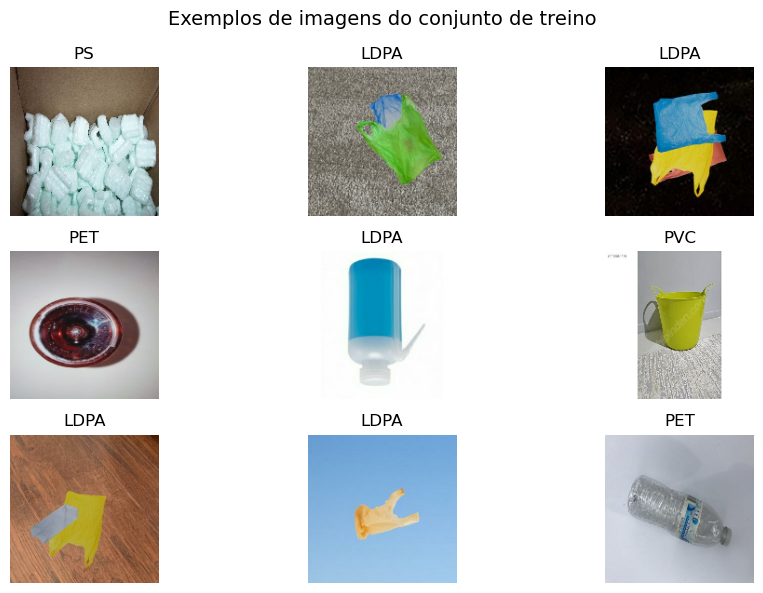

In [11]:
def plot_sample_images(dataset, class_names):
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")
    plt.suptitle("Exemplos de imagens do conjunto de treino", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_sample_images(train_ds, class_names)

In [12]:
for images, labels in train_ds.take(1):
    print("Formato das imagens:", images.shape)
    print("Rótulos:", labels.numpy())

Formato das imagens: (32, 160, 160, 3)
Rótulos: [[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


## Construir modelo CNN simples

In [13]:


model = models.Sequential([
    Input(shape=image_shape),  # Agora é o primeiro bloco
    layers.Rescaling(1./image_color_channel_size),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 158, 158, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 79, 79, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 77, 77, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,402,695 (20.61 MB)

 Trainable params: 5,402,695 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

## Treinamento do modelo

In [16]:
epochs = 10

start_train = time.time()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)
train_time = time.time() - start_train


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.1774 - loss: 2.1203 - val_accuracy: 0.2668 - val_loss: 1.7906
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.2522 - loss: 1.8071 - val_accuracy: 0.3486 - val_loss: 1.7078
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.3729 - loss: 1.6942 - val_accuracy: 0.3774 - val_loss: 1.6582
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.3549 - loss: 1.6240 - val_accuracy: 0.3870 - val_loss: 1.5983
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.4406 - loss: 1.5398 - val_accuracy: 0.3894 - val_loss: 1.5600
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - accuracy: 0.5047 - loss: 1.3306 - val_accuracy: 0.4038 - val_loss: 1.5574
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - accuracy: 0.5598 - loss: 1.2110 - val_accuracy: 0.4014 - val_loss: 1.6293
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.5907 - loss: 1.1348 - val_accuracy: 0.3678 - v

## Visualização da acurácia e loss

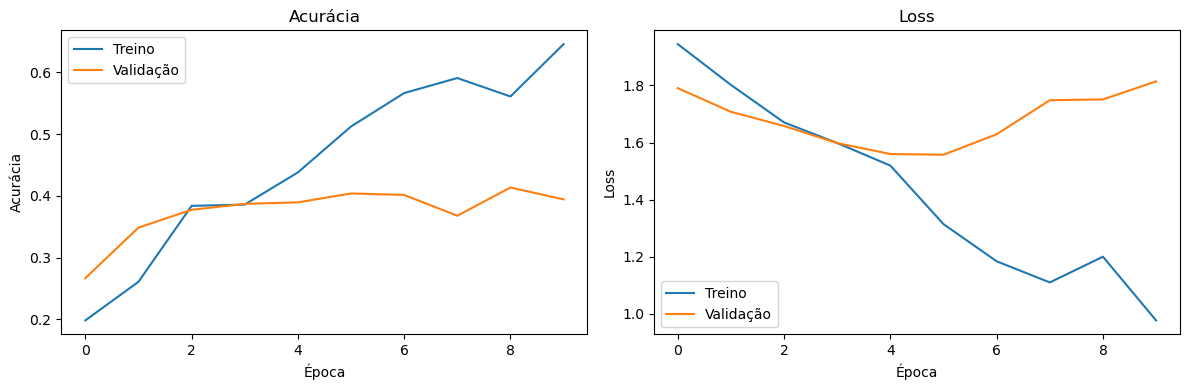

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Avaliar modelo no conjunto de teste

In [20]:
start_infer = time.time()
y_pred_probs = model.predict(test_ds)
inference_time = (time.time() - start_infer) / len(list(test_ds)) * 1000  # ms por batch

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds])

# Avaliação
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
loss_val = log_loss(y_true, y_pred_probs)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names)

print(f"\nAcurácia: {acc:.4f}")
print(f"F1-score ponderado: {f1:.4f}")
print(f"Log Loss: {loss_val:.4f}")
print(f"Tempo médio de inferência por batch: {inference_time:.2f} ms")

print("\nRelatório de Classificação:\n")
print(report)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step

Acurácia: 0.3541
F1-score ponderado: 0.3342
Log Loss: 2.0616
Tempo médio de inferência por batch: 429.30 ms

Relatório de Classificação:

              precision    recall  f1-score   support

        HDPE       0.16      0.13      0.15        30
        LDPA       0.68      0.50      0.58        30
       Other       0.18      0.13      0.15        30
         PET       0.50      0.21      0.29        29
          PP       0.59      0.77      0.67        30
          PS       0.27      0.63      0.38        30
         PVC       0.16      0.10      0.12        30

    accuracy                           0.35       209
   macro avg       0.36      0.35      0.33       209
weighted avg       0.36      0.35      0.33       209



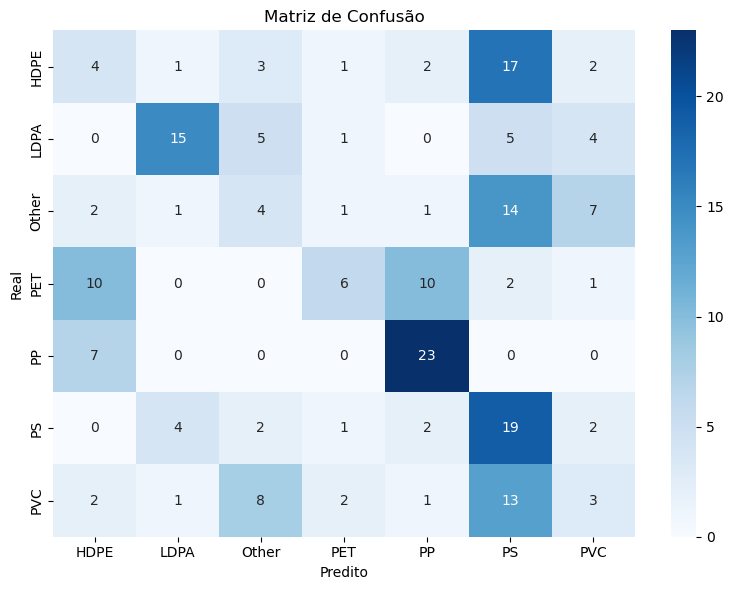

In [21]:
# Matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

## Salvar modelo e métricas

In [24]:
os.makedirs("models/05_cnn", exist_ok=True)
model.save("models/05_cnn/cnn_model.keras")

with open("models/05_cnn/cnn_metrics.json", "w") as f:
    json.dump({
        "model": "cnn",
        "accuracy": acc,
        "f1_score_weighted": f1,
        "log_loss": loss_val,
        "train_time_sec": train_time,
        "inference_time_ms": inference_time
    }, f)

print("\nModelo e métricas salvos com sucesso!")


Modelo e métricas salvos com sucesso!


# analise 

### Análise por partes:
#### ✅ Pontos positivos
    - A acurácia de treinamento evoluiu bem: de 17% → 64%.

    - O loss de treino caiu significativamente: de 2.12 → 1.00.

    - O modelo está aprendendo algo, não é aleatório.

#### ⚠️ Pontos de atenção
    - A acurácia de validação estagnou entre ~38% e 41%, sem acompanhar o ganho no treino.

    - O loss de validação aumentou após a 6ª época → overfitting detectado.

    - Generalização ruim: o modelo aprendeu os dados de treino, mas não consegue aplicar bem em dados não vistos.

#### 🧠 Conclusão
Seu modelo CNN simples está overfittando: aprende muito bem o treino, mas não transfere esse aprendizado para a validação.

### 🛠️ Próximos passos recomendados

1. Reduza o overfitting com:

    - Dropout entre as camadas densas (ex: Dropout(0.5))

    - Data augmentation com ImageDataGenerator ou layers.RandomFlip/Rotation/etc

    - EarlyStopping no ModelCheckpoint

2. Aumente a capacidade do modelo de forma controlada:

    - Adicionar mais filtros (ex: 64 → 128)

    - Mais camadas convolucionais com BatchNormalization

3. Ajuste hiperparâmetros:

    - Aprendizado: use ReduceLROnPlateau

    - Batch size menor (ex: 16)

    - Mais épocas (com early stopping)

4. Experimente transferência de aprendizado:

     - Use um modelo pré-treinado como MobileNetV2 ou ResNet50 com include_top=False

